In [1]:
import torch
import torch.utils.data 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fix random seed

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Cuda/MPS

In [4]:
use_cuda_if_available = True

# Dataloader

In [5]:
### Define the custom PyTorch dataloader for this assignment
class dataloader(torch.utils.data.Dataset):
    """Loads the KITTI Odometry Benchmark Dataset"""
    def __init__(self, matfile, binsize=45, mode='train'):
        self.data = sio.loadmat(matfile)
        
        self.images = self.data['images']
        self.mode = mode

        # Fill in this function if you wish to normalize the input
        # Data to zero mean.
        self.normalize_to_zero_mean()
        
        if self.mode != 'test':

            # Generate targets for images by 'digitizing' each azimuth 
            # angle into the appropriate bin (from 0 to num_bins)
            self.azimuth = self.data['azimuth']
            bin_edges = np.arange(-180,180+1,binsize)
            self.targets = (np.digitize(self.azimuth,bin_edges) -1).reshape((-1))

    def normalize_to_zero_mean(self):
        # Calculate the mean for each channel
        mean = np.mean(self.images, axis=(0, 1, 2))
        self.images = self.images - mean

    def __len__(self):
        return int(self.images.shape[0])
  
    def __getitem__(self, idx):
        if self.mode != 'test':
            return self.images[idx], self.targets[idx]    
        else:
            return self.images[idx]

In [6]:
binsize=20 #degrees **set this to 20 for part 2**
bin_edges = np.arange(-180,180+1,binsize)
num_bins = bin_edges.shape[0] - 1
dsets = {x: dataloader('sun-cnn_{}.mat'.format(x),binsize=binsize) for x in ['train', 'val']} 
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=64, shuffle=True, num_workers=0) for x in ['train', 'val']}
print("finish loading data")
loss = {'train': [], 'val': []}
top1err = {'train': [], 'val': []}
top5err = {'train': [], 'val': []}
best_err = 1

finish loading data


# CNN Class

In [7]:
class CNN(torch.nn.Module):
    def __init__(self, num_bins): 
        super(CNN, self).__init__()

        # Define the layers directly within the class
        self.network = torch.nn.Sequential(
            # First Convolutional Block
            torch.nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            # # Second Convolutional Block
            # torch.nn.Conv2d(16, 32, kernel_size=7, padding=2),
            # torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(32),
            # torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth Convolutional Block
            torch.nn.Conv2d(32, 64, kernel_size=5, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            # Flatten the output for the fully connected layers
            torch.nn.Flatten(),

            # Fully Connected Layers
            torch.nn.Linear(9984, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(1024, num_bins)
        )

        if use_cuda_if_available and torch.cuda.is_available():
            self = self.cuda()

    ###Define what the forward pass through the network is
    def forward(self, x):
        x = self.network(x)
        x = x.squeeze() # (Batch_size x num_bins x 1 x 1) to (Batch_size x num_bins)

        return x

# Train

## Network Initialization

In [8]:
cnn = CNN(num_bins) #Initialize our CNN Class

CE_loss = torch.nn.CrossEntropyLoss(reduction='sum') #initialize our loss (specifying that the output as a sum of all sample losses)
params = list(cnn.parameters())
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay= 0.0000001, amsgrad=True)

## Training Loop

In [9]:
for epoch in tqdm(range(0,15)):
    for mode in ['train', 'val']:    #iterate 
        epoch_loss=0
        top1_incorrect = 0
        top5_incorrect = 0
        if mode == 'train':
            cnn.train(True)    # Set model to training mode
        else:
            cnn.train(False)    # Set model to Evaluation mode
            cnn.eval()
        
        dset_size = dset_loaders[mode].dataset.__len__()
        for image, target in dset_loaders[mode]:    #Iterate through all data (each iteration loads a minibatch)
            # Cast to types and Load GPU if desired and available
            if use_cuda_if_available and torch.cuda.is_available():
                image = image.cuda().type(torch.cuda.FloatTensor)
                target = target.cuda().type(torch.cuda.LongTensor)
            else:
                image = image.type(torch.FloatTensor)
                target = target.type(torch.LongTensor)
            optimizer.zero_grad()    #zero the gradients of the cnn weights prior to backprop
            pred = cnn(image)   # Forward pass through the network
            minibatch_loss = CE_loss(pred, target)  #Compute the minibatch loss
            epoch_loss += minibatch_loss.item() #Add minibatch loss to the epoch loss 
            
            if mode == 'train': #only backprop through training loss and not validation loss       
                minibatch_loss.backward()
                optimizer.step()        
                    
            
            _, predicted = torch.max(pred.data, 1) #from the network output, get the class prediction
            top1_incorrect += (predicted != target).sum().item() #compute the Top 1 error rate
            
            top5_val, top5_idx = torch.topk(pred.data,5,dim=1)
            top5_incorrect += ((top5_idx != target.view((-1,1))).sum(dim=1) == 5).sum().item() #compute the top5 error rate

        loss[mode].append(epoch_loss/dset_size)
        top1err[mode].append(top1_incorrect/dset_size)
        top5err[mode].append(top5_incorrect/dset_size)

        print("{} Loss: {}".format(mode, loss[mode][epoch]))
        print("{} Top 1 Error: {}".format(mode, top1err[mode][epoch]))    
        print("{} Top 5 Error: {}".format(mode, top5err[mode][epoch])) 
        if mode == 'val':
            print("Completed Epoch {}".format(epoch))
            if top1err['val'][epoch] < best_err:
                best_err = top1err['val'][epoch]
                best_epoch = epoch
                torch.save(cnn.state_dict(), 'best_model_{}.pth'.format(binsize))

print("Training Complete")
print("Lowest validation set error of {} at epoch {}".format(np.round(best_err,2), best_epoch))        

  0%|          | 0/15 [00:00<?, ?it/s]

train Loss: 0.47461248140169615
train Top 1 Error: 0.1429358303497659
train Top 5 Error: 0.03828146516111264


  7%|▋         | 1/15 [00:05<01:22,  5.93s/it]

val Loss: 2.127164738950595
val Top 1 Error: 0.4154929577464789
val Top 5 Error: 0.1732394366197183
Completed Epoch 0
train Loss: 0.08046381651156863
train Top 1 Error: 0.023134122831175986
train Top 5 Error: 0.000550812448361333


 13%|█▎        | 2/15 [00:08<00:52,  4.01s/it]

val Loss: 1.7467889812630666
val Top 1 Error: 0.35492957746478876
val Top 5 Error: 0.11830985915492957
Completed Epoch 1
train Loss: 0.061803957198612355
train Top 1 Error: 0.018176810795923988
train Top 5 Error: 0.0002754062241806665


 20%|██        | 3/15 [00:11<00:40,  3.37s/it]

val Loss: 3.197041610932686
val Top 1 Error: 0.5915492957746479
val Top 5 Error: 0.2
Completed Epoch 2
train Loss: 0.054943147288541494
train Top 1 Error: 0.011567061415587993
train Top 5 Error: 0.001101624896722666


 27%|██▋       | 4/15 [00:13<00:33,  3.07s/it]

val Loss: 2.506409540310712
val Top 1 Error: 0.4197183098591549
val Top 5 Error: 0.23098591549295774
Completed Epoch 3
train Loss: 0.040205917080812496
train Top 1 Error: 0.010740842743045993
train Top 5 Error: 0.0002754062241806665


 33%|███▎      | 5/15 [00:16<00:29,  2.95s/it]

val Loss: 2.1513454967821146
val Top 1 Error: 0.4507042253521127
val Top 5 Error: 0.2028169014084507
Completed Epoch 4
train Loss: 0.03951977261377248
train Top 1 Error: 0.00853759294960066
train Top 5 Error: 0.0


 40%|████      | 6/15 [00:19<00:26,  2.93s/it]

val Loss: 2.2950963517309915
val Top 1 Error: 0.45211267605633804
val Top 5 Error: 0.20140845070422536
Completed Epoch 5
train Loss: 0.026964024056587394
train Top 1 Error: 0.007711374277058662
train Top 5 Error: 0.0002754062241806665


 47%|████▋     | 7/15 [00:22<00:22,  2.84s/it]

val Loss: 2.5839682887977276
val Top 1 Error: 0.4647887323943662
val Top 5 Error: 0.223943661971831
Completed Epoch 6
train Loss: 0.012818795122786908
train Top 1 Error: 0.0033048746901679976
train Top 5 Error: 0.0


 53%|█████▎    | 8/15 [00:24<00:19,  2.77s/it]

val Loss: 2.4406113826053244
val Top 1 Error: 0.44929577464788734
val Top 5 Error: 0.21549295774647886
Completed Epoch 7
train Loss: 0.011384395316794117
train Top 1 Error: 0.0024786560176259984
train Top 5 Error: 0.0


 60%|██████    | 9/15 [00:27<00:16,  2.72s/it]

val Loss: 2.279163433800281
val Top 1 Error: 0.4211267605633803
val Top 5 Error: 0.18732394366197183
Completed Epoch 8
train Loss: 0.015705336503688626
train Top 1 Error: 0.002754062241806665
train Top 5 Error: 0.0


 67%|██████▋   | 10/15 [00:29<00:13,  2.69s/it]

val Loss: 2.521625914036388
val Top 1 Error: 0.48450704225352115
val Top 5 Error: 0.19014084507042253
Completed Epoch 9
train Loss: 0.02905274835997165
train Top 1 Error: 0.00550812448361333
train Top 5 Error: 0.0002754062241806665


 73%|███████▎  | 11/15 [00:32<00:10,  2.69s/it]

val Loss: 2.730322617544255
val Top 1 Error: 0.48450704225352115
val Top 5 Error: 0.24225352112676057
Completed Epoch 10
train Loss: 0.0217559033826802
train Top 1 Error: 0.005783530707793996
train Top 5 Error: 0.0002754062241806665


 80%|████████  | 12/15 [00:35<00:08,  2.67s/it]

val Loss: 2.7150585523793396
val Top 1 Error: 0.44929577464788734
val Top 5 Error: 0.1676056338028169
Completed Epoch 11
train Loss: 0.014849912458699873
train Top 1 Error: 0.0033048746901679976
train Top 5 Error: 0.0002754062241806665


 87%|████████▋ | 13/15 [00:37<00:05,  2.67s/it]

val Loss: 2.983387499795833
val Top 1 Error: 0.47183098591549294
val Top 5 Error: 0.18591549295774648
Completed Epoch 12
train Loss: 0.0371476370026646
train Top 1 Error: 0.004957312035251997
train Top 5 Error: 0.0008262186725419994


 93%|█████████▎| 14/15 [00:40<00:02,  2.66s/it]

val Loss: 2.749362691691224
val Top 1 Error: 0.5169014084507042
val Top 5 Error: 0.18873239436619718
Completed Epoch 13
train Loss: 0.024158514173266907
train Top 1 Error: 0.00468190581107133
train Top 5 Error: 0.0002754062241806665


100%|██████████| 15/15 [00:43<00:00,  2.88s/it]

val Loss: 4.057569562885123
val Top 1 Error: 0.49577464788732395
val Top 5 Error: 0.24647887323943662
Completed Epoch 14
Training Complete
Lowest validation set error of 0.35 at epoch 1


## Plot

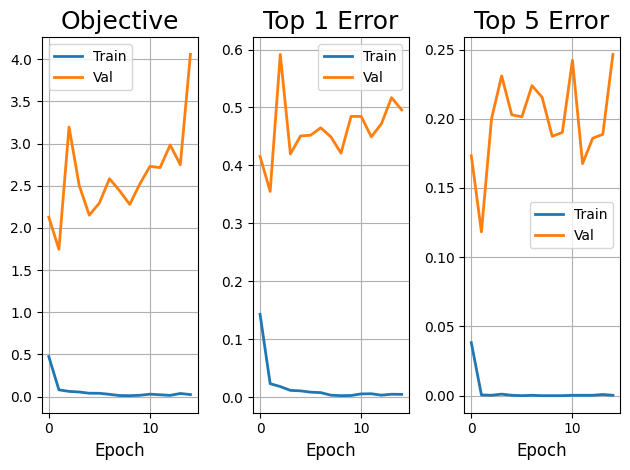

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.grid()
ax1.plot(loss['train'],linewidth=2)
ax1.plot(loss['val'],linewidth=2)
#ax1.legend(['Train', 'Val'],fontsize=12)
ax1.legend(['Train', 'Val'])
ax1.set_title('Objective', fontsize=18, color='black')
ax1.set_xlabel('Epoch', fontsize=12)

ax2.grid()
ax2.plot(top1err['train'],linewidth=2)
ax2.plot(top1err['val'],linewidth=2)
ax2.legend(['Train', 'Val'])
ax2.set_title('Top 1 Error', fontsize=18, color='black')
ax2.set_xlabel('Epoch', fontsize=12)

ax3.grid()
ax3.plot(top5err['train'],linewidth=2)
ax3.plot(top5err['val'],linewidth=2)
ax3.legend(['Train', 'Val'])
ax3.set_title('Top 5 Error', fontsize=18, color='black')
ax3.set_xlabel('Epoch', fontsize=12)
plt.tight_layout()
plt.show()
fig.savefig('net-train.pdf')